In [24]:
import os
import sys
import json
import random
import numpy as np
sys.path.append('../src')
import subprocess
from datetime import datetime
import requests
import tempfile
from rasterio.features import geometry_mask
from rasterio.mask import mask
import rasterio
import matplotlib.pyplot as plt

In [69]:
def get_satellite_products(satellite, lake, product, bucket="https://eawagrs.s3.eu-central-1.amazonaws.com"):
    url = "{}/metadata/{}/{}_{}.json".format(bucket, satellite, lake, product)
    response = requests.get(url)
    return response.json()

In [70]:
def generate_random_points(bbox, n):
    min_lon, min_lat, max_lon, max_lat = bbox
    random_points = []
    for _ in range(n):
        random_lon = random.uniform(min_lon, max_lon)
        random_lat = random.uniform(min_lat, max_lat)
        random_points.append((random_lon, random_lat))
    return random_points

In [71]:
def get_image(url, boundary, particles, valid_pixel_expression=True, percentile=0):
    response = requests.get(url)
    if response.status_code == 200:
        image_data = response.content
        with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as temp_file:
            temp_file.write(image_data)
            temp_file_path = temp_file.name
            with rasterio.open(temp_file_path) as src:
                masked_image, masked_transform = mask(src, [boundary], crop=True)
                
                if valid_pixel_expression:
                    valid_mask = (masked_image[0] != src.nodata) & (masked_image[0] != 0) & (masked_image[1] == 0)
                else:
                    valid_mask = (masked_image[0] != src.nodata) & (masked_image[0] != 0)

                valid_points = np.argwhere(valid_mask)
                valid_values = masked_image[0, valid_points[:, 0], valid_points[:, 1]]
                valid_latitudes = []
                valid_longitudes = []
                valid_colors = []
                out=[]
                
                total = np.nansum(valid_values)
                percentile = np.percentile(valid_values, percentile)
                all_random_points = []
                all_cell_values = []

                for idx, (row, col) in enumerate(valid_points):
                    if valid_values[idx] > percentile:
                        lon, lat = rasterio.transform.xy(masked_transform, row, col)
                        valid_latitudes.append(lat)
                        valid_longitudes.append(lon)
                        n = int((valid_values[idx] / total ) * particles)

                        bbox = (lon, lat, lon + masked_transform.a, lat + masked_transform.e)
                        random_points = generate_random_points(bbox, n)
                        all_random_points.extend(random_points)
                        all_cell_values.extend([valid_values[idx]] * n)
                    
                    
                plt.plot(*zip(*boundary["coordinates"][0]), color='k', label='Original Geometry')
                random_longitudes, random_latitudes = zip(*all_random_points)
                plt.scatter(random_longitudes, random_latitudes, c=all_cell_values, s=.5, cmap='viridis', marker='x', label='Random Points')

                plt.colorbar(label='Pixel Value')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.legend()
                plt.show()
        temp_file.close()
    else:
        print("Failed to download image. Status code:", response.status_code)

In [72]:
def get_lake_boundaries(bucket="https://eawagrs.s3.eu-central-1.amazonaws.com"):
    url = "{}/metadata/lakes.json".format(bucket)
    response = requests.get(url)
    return response.json()

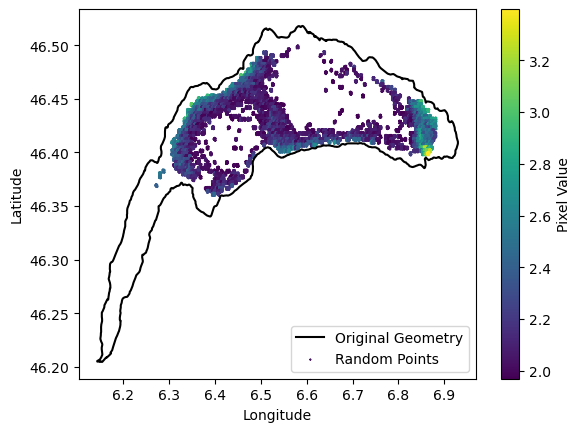

In [74]:
lake = "geneva"
particles = 100000
bucket = "https://eawagrs.s3.eu-central-1.amazonaws.com"
images = get_satellite_products("sentinel3", "geneva", "tsm_binding754")
lakes = get_lake_boundaries()
boundary = {
    "type": "Polygon",
    "coordinates": [d for d in lakes["features"] if d["properties"]["Name"] == lake][0]["geometry"]["coordinates"]
}
url = bucket + "/" + images[-1]["k"]
get_image(url, boundary, particles, percentile=60)

In [55]:
images[-1]["k"]

'datalakes/sui/S3B_20230823T094909/POLYMER_tsm_binding754_S3B_20230823T094909_sui.tif'

In [7]:
images

[{'dt': '20230223T102037',
  'k': 'datalakes/sui/S3A_20230223T102037/SECCHIDEPTH_Zsd_lee_S3A_20230223T102037_sui.tif',
  'p': 6455,
  'vp': 41,
  'min': 3.289026975631714,
  'max': 8.302153587341309,
  'mean': 6.67279052734375},
 {'dt': '20230224T095426',
  'k': 'datalakes/sui/S3A_20230224T095426/SECCHIDEPTH_Zsd_lee_S3A_20230224T095426_sui.tif',
  'p': 6455,
  'vp': 3824,
  'min': 3.396599292755127,
  'max': 8.82357120513916,
  'mean': 6.243758678436279},
 {'dt': '20230225T092815',
  'k': 'datalakes/sui/S3A_20230225T092815/SECCHIDEPTH_Zsd_lee_S3A_20230225T092815_sui.tif',
  'p': 6455,
  'vp': 1384,
  'min': 2.150933265686035,
  'max': 9.184362411499023,
  'mean': 6.217319011688232},
 {'dt': '20230227T101652',
  'k': 'datalakes/sui/S3A_20230227T101652/SECCHIDEPTH_Zsd_lee_S3A_20230227T101652_sui.tif',
  'p': 6455,
  'vp': 1487,
  'min': 1.6722006797790527,
  'max': 17.395023345947266,
  'mean': 9.420467376708984},
 {'dt': '20230228T095041',
  'k': 'datalakes/sui/S3A_20230228T095041/SECCH